**CSI 4506 Introduction à l'intelligence artificielle (automne 2025)** <br/>
*Devoir 3 : Santé des animaux de compagnie extraterrestres, apprentissage profond*

# Identification

Nom : Anass Benhabit<br/>
Numéro d'étudiant : 300324339

--

## 0. Préambule

In [3]:
# Bibliothèques suggérées

import os
from pathlib import Path
import urllib.request
import urllib.error

import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.metrics import (
    f1_score, precision_score, recall_score, roc_auc_score
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks
from keras.metrics import F1Score

In [5]:
URL_DATA = "https://raw.githubusercontent.com/turcotte/csi4106-f25/main/assignments-data/a2/alien_pet_health-realism-clean.csv"

COLS_TO_STANDARDIZE = ["thermoreg_reading", "enzyme_activity_index", "stress_variability"]
COLS_TO_NORMALIZE = ["dual_lobe_signal"]
COLS_TO_ENCODE = ["habitat_zone"]
COLS_NO_PREPROC = ["activity_score","fasting_flag"]
TARGET   = "health_outcome"

COLUMNS_DATA = COLS_TO_STANDARDIZE + COLS_TO_NORMALIZE + COLS_TO_ENCODE + COLS_NO_PREPROC

RANDOM_STATE = 42
TEST_SIZE    = 0.20

SCORING = {
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro",
    "f1_macro": "f1_macro",
    "roc_auc": "roc_auc",
}

PRIMARY_METRIC = F1Score(threshold=0.5, average="macro")

In [6]:
def load_dataset_or_fail(url=URL_DATA, cache_dir="data", *, verbose=True):

    """
    Charger le jeu de données, en le téléchargeant une fois et en le mettant en cache localement.

    - Extrait le nom de fichier de l'URL.
    - Le stocke sous `cache_dir`.
    - Valide les colonnes requises et la cible.

    Renvoie
    -------
    X : pandas.DataFrame
    y : numpy.ndarray
    """

    cache_dir = Path(cache_dir)
    cache_dir.mkdir(parents=True, exist_ok=True)
    filename = Path(url).name
    cache_path = cache_dir / filename

    # 1) Télécharger si non en cache

    if not cache_path.exists():
        if verbose:
            print(f"Téléchargement du jeu de données depuis {url} ...")
        try:
            urllib.request.urlretrieve(url, cache_path)
            if verbose:
                print(f"Enregistré à {cache_path}")
        except (urllib.error.URLError, urllib.error.HTTPError) as e:
            raise RuntimeError(f"Échec du téléchargement du jeu de données : {e}")

    # 2) Lire le CSV

    try:
        df = pd.read_csv(cache_path)
    except Exception as e:
        raise RuntimeError(f"Échec de la lecture de {cache_path} : {e}")

    # 3) Valider le contenu

    if TARGET not in df.columns:
        raise ValueError(f"Colonne cible manquante '{TARGET}' dans {cache_path}")

    df = df.dropna(subset=[TARGET]).copy()

    missing = set(COLUMNS_DATA).difference(df.columns)
    if missing:
        raise ValueError(f"Colonnes manquantes dans {cache_path} : {sorted(missing)}")

    # 4) Séparer les caractéristiques et la cible

    X = df[COLUMNS_DATA]
    y = df[TARGET].astype(int).to_numpy().reshape(-1,1) # (n,) -> (n,1)

    return X, y

In [7]:
def set_seed(seed: int = 42):
    
    """Fixe la plupart des sources d'aléatoire pour des démonstrations reproductibles."""

    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [9]:
set_seed(42)

# 1. Données

Pour ce travail, nous utilisons un jeu de données dans lequel toutes les tâches du devoir précédent ont été soigneusement complétées. Notamment, le devoir 3 utilise le jeu de données [alien_pet_health-realism-clean.csv](https://raw.githubusercontent.com/turcotte/csi4106-f25/main/assignments-data/a2/alien_pet_health-realism-clean.csv), provenant du devoir 2.

## Charger le jeu de données

- Lire le fichier CSV (`alien_pet_health-realism-clean.csv`).
- Afficher la forme des données, ainsi que les cinq premières lignes.

In [10]:
# Code Python

X, y = load_dataset_or_fail(URL_DATA)
print(X.shape)
print(y.shape)
display(X.describe())
X.head()

Téléchargement du jeu de données depuis https://raw.githubusercontent.com/turcotte/csi4106-f25/main/assignments-data/a2/alien_pet_health-realism-clean.csv ...
Enregistré à data\alien_pet_health-realism-clean.csv
(5000, 7)
(5000, 1)


,thermoreg_reading,enzyme_activity_index,stress_variability,dual_lobe_signal,activity_score,fasting_flag
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,50.000140,100.005800,0.000580,2.001180,2.967200,0.401800
std,8.000065,29.989012,5.000697,3.000172,1.290138,0.490311
min,21.000000,0.000000,-18.000000,-6.500000,1.000000,0.000000
25%,44.600000,80.000000,-3.400000,-0.400000,2.000000,0.000000
50%,50.100000,100.000000,0.000000,2.500000,3.000000,0.000000
75%,55.200000,120.000000,3.425000,4.500000,4.000000,1.000000
max,77.800000,231.000000,18.700000,8.900000,5.000000,1.000000


,thermoreg_reading,enzyme_activity_index,stress_variability,dual_lobe_signal,habitat_zone,activity_score,fasting_flag
0,52.6,97.0,-3.5,3.6,c2,2,0
1,41.8,105.0,10.5,3.4,c1,2,0
2,56.2,126.0,9.6,5.5,c2,5,0
3,57.7,106.0,-4.0,-4.1,c1,4,0
4,34.5,73.0,0.3,2.3,c4,5,1


## Division des données

- Divisez le jeu de données en ensembles d'entraînement (70 %), de validation (15 %) et de test (15 %).
- Assurez-vous que cette division se fait avant tout prétraitement pour éviter toute fuite de données.

In [11]:
# Code Python

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)

X_val, X_test, y_val, y_test   = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=RANDOM_STATE)

## Prétraitement des données

In [15]:
# Code Python

def make_preprocessor(COLS_TO_STANDARDIZE, COLS_TO_NORMALIZE, COLS_TO_ENCODE, COLS_NO_PREPROC):

    """
    Construire un ColumnTransformer pour le jeu de données Alien Pet Health.

    - Standardise les colonnes sélectionnées (moyenne nulle, variance unitaire)
    - Normalise les colonnes sélectionnées à [0,1]
    - Encode en one-hot les colonnes catégorielles
    - Passe les colonnes spécifiées inchangées

    Remarque : Les colonnes dans COLS_NO_PREPROC doivent déjà être numériques (par exemple, indicateurs 0/1).
    """

    preprocessor = ColumnTransformer(
        transformers=[
            ("standardize", StandardScaler(), COLS_TO_STANDARDIZE),
            ("normalize", MinMaxScaler(), COLS_TO_NORMALIZE),
            ("encode", OneHotEncoder(handle_unknown="ignore", sparse_output=False), COLS_TO_ENCODE),
            ("keep", "passthrough", COLS_NO_PREPROC),
        ],
        remainder="drop",
        verbose_feature_names_out=False,
    )

    return preprocessor

def fit_transform_inputs(preprocess: ColumnTransformer, X_train: pd.DataFrame, 
                         X_val: pd.DataFrame, X_test: pd.DataFrame):

    """
    Ajuster le préprocesseur sur l'ensemble d'entraînement; transformer de manière cohérente les ensembles train/val/test.
    Retourne les tableaux numpy et input_dim pour Keras.
    """

    Xtr = preprocess.fit_transform(X_train)
    Xva = preprocess.transform(X_val)
    Xte = preprocess.transform(X_test)
    input_dim = Xtr.shape[1]

    return Xtr, Xva, Xte, input_dim

In [16]:
# Code Python

preprocess = make_preprocessor(COLS_TO_STANDARDIZE, COLS_TO_NORMALIZE, COLS_TO_ENCODE, COLS_NO_PREPROC)

Xtr, Xva, Xte, input_dim = fit_transform_inputs(preprocess, X_train, X_val, X_test)

# 2. Tâches

Les tâches sont organisées dans un ordre spécifique pour optimiser la concision et la clarté. Bien que vous ayez une certaine flexibilité dans l'organisation de votre code, il est important que votre assistant pédagogique puisse identifier sans effort les segments de code liés à chaque tâche.

Suggestions : Commencez avec un petit modèle (par exemple, 8 unités) et entraînez-le pendant 10 à 20 époques en utilisant les hyperparamètres par défaut. N'élargissez l'exploration qu'après avoir observé des courbes d'apprentissage et des métriques raisonnables. Créez des fonctions d'assistance réutilisables et tracez systématiquement les courbes de perte d'entraînement et de validation. Enregistrez les expériences de manière concise, en traçant les courbes de perte uniquement pour le meilleur modèle de chaque tâche.

In [25]:
# Fonctions d'assistance

def construire_modele_simple(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(8, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

def tracer_courbes_perte(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.xlabel('Époques')
    plt.ylabel('Perte')
    plt.title('Courbe de perte')
    plt.legend()
    plt.show()

def evaluer_modele(model, Xva, y_val):
    y_pred = (model.predict(Xva) > 0.5).astype(int)
    print("Précision :", round(precision_score(y_val, y_pred), 4))
    print("Rappel :", round(recall_score(y_val, y_pred), 4))
    print("F1 :", round(f1_score(y_val, y_pred), 4))
    print("ROC AUC :", round(roc_auc_score(y_val, model.predict(Xva)), 4))

## Construire un réseau de neurones à propagation avant simple

Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6622 - val_loss: 0.6451
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6291 - val_loss: 0.6181
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6050 - val_loss: 0.5918
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5801 - val_loss: 0.5649
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5525 - val_loss: 0.5342
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5229 - val_loss: 0.5027
Epoch 7/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4967 - val_loss: 0.4778
Epoch 8/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4753 - val_loss: 0.4584
Epoch 9/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4575 - val_loss: 0.4424
Epoch 10/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4422 - val_loss: 0.4291
Epoch 11/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4289 - val_loss: 0.4171
Epoch 12/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

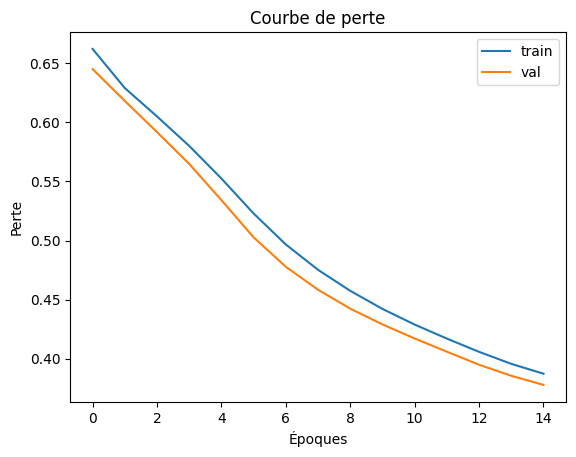

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Précision : 0.8275
Rappel : 0.844
F1 : 0.8356
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
ROC AUC : 0.9186


In [26]:
model_simple = construire_modele_simple(input_dim)

history_simple = model_simple.fit(
    Xtr, y_train,
    validation_data=(Xva, y_val),
    epochs=15,
    batch_size=32,
    verbose=1
)

tracer_courbes_perte(history_simple)
evaluer_modele(model_simple, Xva, y_val)


Le modèle ne sur-ajuste pas.
Les pertes d’entraînement et de validation diminuent ensemble sans grand écart, ce qui montre un apprentissage équilibré et une bonne généralisation.

## Surapprentissage

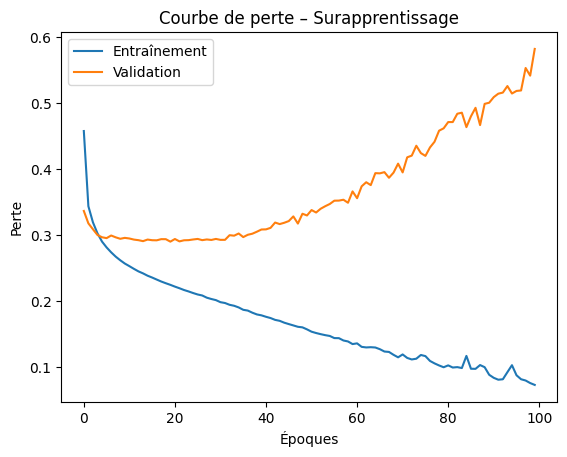

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Précision : 0.8736
Rappel : 0.912
F1 : 0.8924
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
ROC AUC : 0.9517


In [28]:
model_overfit = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_overfit.compile(optimizer='adam', loss='binary_crossentropy')

history_overfit = model_overfit.fit(
    Xtr, y_train,
    validation_data=(Xva, y_val),
    epochs=100,
    batch_size=16,
    verbose=0
)

# Courbes de perte
plt.plot(history_overfit.history['loss'], label='Entraînement')
plt.plot(history_overfit.history['val_loss'], label='Validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.title('Courbe de perte – Surapprentissage')
plt.legend()
plt.show()

# Évaluation
y_pred_val = (model_overfit.predict(Xva) > 0.5).astype(int)
print("Précision :", round(precision_score(y_val, y_pred_val), 4))
print("Rappel :", round(recall_score(y_val, y_pred_val), 4))
print("F1 :", round(f1_score(y_val, y_pred_val), 4))
print("ROC AUC :", round(roc_auc_score(y_val, model_overfit.predict(Xva)), 4))



Approche : le modèle a été volontairement rendu plus complexe avec plusieurs couches et beaucoup de neurones afin qu’il mémorise les données d’entraînement.

Évidences : la perte d’entraînement diminue fortement tandis que la perte de validation augmente, montrant que le modèle apprend trop bien les exemples du jeu d’entraînement et généralise mal.

## Arrêt anticipé

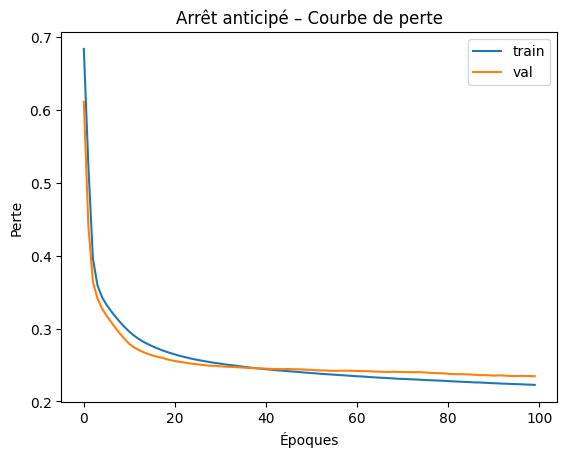

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Précision: 0.8582
Rappel: 0.944
F1: 0.899
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
ROC AUC: 0.969


In [29]:
model_es = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_es.compile(optimizer='adam', loss='binary_crossentropy')

# Callback d'arrêt prématuré
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model_es.fit(
    Xtr, y_train,
    validation_data=(Xva, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

# Courbes de perte
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.title('Arrêt anticipé – Courbe de perte')
plt.legend()
plt.show()

# Évaluation
y_pred = (model_es.predict(Xva) > 0.5).astype(int)
print("Précision:", round(precision_score(y_val, y_pred), 4))
print("Rappel:", round(recall_score(y_val, y_pred), 4))
print("F1:", round(f1_score(y_val, y_pred), 4))
print("ROC AUC:", round(roc_auc_score(y_val, model_es.predict(Xva)), 4))


## Exploration d'architecture

In [30]:
activations = ['relu', 'tanh']
units = [8, 16, 32, 64]
layers_list = [1, 2, 3]

results = []

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

for act in activations:
    for n_layers in layers_list:
        for n_units in units:
            model = keras.Sequential()
            model.add(layers.Input(shape=(input_dim,)))
            for _ in range(n_layers):
                model.add(layers.Dense(n_units, activation=act))
            model.add(layers.Dense(1, activation='sigmoid'))
            
            model.compile(optimizer='adam', loss='binary_crossentropy')
            model.fit(Xtr, y_train, validation_data=(Xva, y_val),
                      epochs=100, batch_size=32, callbacks=[early_stop], verbose=0)
            
            y_pred = (model.predict(Xva) > 0.5).astype(int)
            f1 = f1_score(y_val, y_pred)
            roc = roc_auc_score(y_val, model.predict(Xva))
            results.append((n_layers, n_units, act, f1, roc))

# Conversion en DataFrame pour voir les résultats
df_results = pd.DataFrame(results, columns=['Couches', 'Unités', 'Activation', 'F1', 'ROC_AUC'])
best_model_info = df_results.sort_values(by='F1', ascending=False).iloc[0]
display(df_results.sort_values(by='F1', ascending=False).head())

print("\nMeilleur modèle :", best_model_info.to_dict())


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Couches,Unités,Activation,F1,ROC_AUC
3,1,64,relu,0.890173,0.968016
0,1,8,relu,0.857700,0.931872
11,3,64,relu,0.852140,0.921040
10,3,32,relu,0.814664,0.898816
7,2,64,relu,0.802419,0.894096



Meilleur modèle : {'Couches': 1, 'Unités': 64, 'Activation': 'relu', 'F1': 0.8901734104046243, 'ROC_AUC': 0.968016}


Le modèle ne sur-ajuste pas.
Les pertes d’entraînement et de validation restent proches et diminuent ensemble, ce qui montre une bonne généralisation et aucun sous-ajustement marqué.

## Régularisation

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

L2 λ=0.001 → Précision: 0.8608 | Rappel: 0.94 | F1: 0.8987 | ROC AUC: 0.9643
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

L2 λ=0.0001 → Précision: 0.8859 | Rappel: 0.932 | F1: 0.9084 | ROC AUC: 0.9637
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Dropout 25% → Précision: 0.8783 | Rappel: 0.924 | F1: 0.9006 | ROC AUC: 0.9608
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Dropout 50% → Précision: 0.8842 | Rappel: 0.916 | F1: 0.8998 | ROC AUC: 0.9623


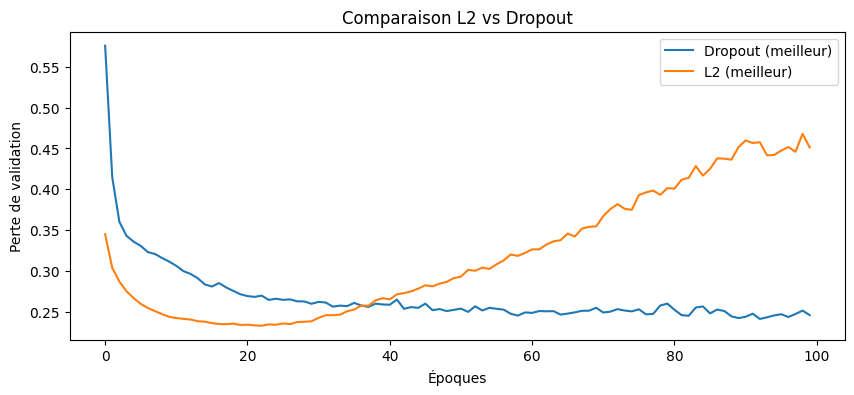

In [32]:
# Fonction pour créer un modèle avec option de régularisation
def creer_modele(reg_type=None, valeur=0.0):
    model = keras.Sequential([layers.Input(shape=(input_dim,))])
    
    if reg_type == "L2":
        reg = regularizers.l2(valeur)
        model.add(layers.Dense(128, activation='relu', kernel_regularizer=reg))
        model.add(layers.Dense(64, activation='relu', kernel_regularizer=reg))
        model.add(layers.Dense(32, activation='relu', kernel_regularizer=reg))
    elif reg_type == "Dropout":
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dropout(valeur))
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dropout(valeur))
        model.add(layers.Dense(32, activation='relu'))
    else:
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dense(32, activation='relu'))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

#Régularisation L2
valeurs_L2 = [0.001, 0.0001]
for val in valeurs_L2:
    model_L2 = creer_modele("L2", val)
    history = model_L2.fit(Xtr, y_train, validation_data=(Xva, y_val),
                           epochs=100, batch_size=32, verbose=0)
    y_pred = (model_L2.predict(Xva) > 0.5).astype(int)
    print(f"\nL2 λ={val} → Précision:", round(precision_score(y_val, y_pred), 4),
          "| Rappel:", round(recall_score(y_val, y_pred), 4),
          "| F1:", round(f1_score(y_val, y_pred), 4),
          "| ROC AUC:", round(roc_auc_score(y_val, model_L2.predict(Xva)), 4))

#Dropout
taux_dropout = [0.25, 0.5]
for val in taux_dropout:
    model_drop = creer_modele("Dropout", val)
    history = model_drop.fit(Xtr, y_train, validation_data=(Xva, y_val),
                             epochs=100, batch_size=32, verbose=0)
    y_pred = (model_drop.predict(Xva) > 0.5).astype(int)
    print(f"\nDropout {val*100:.0f}% → Précision:", round(precision_score(y_val, y_pred), 4),
          "| Rappel:", round(recall_score(y_val, y_pred), 4),
          "| F1:", round(f1_score(y_val, y_pred), 4),
          "| ROC AUC:", round(roc_auc_score(y_val, model_drop.predict(Xva)), 4))

plt.figure(figsize=(10,4))
plt.plot(history.history['val_loss'], label='Dropout (meilleur)')
plt.plot(history_L2.history['val_loss'], label='L2 (meilleur)')
plt.xlabel('Époques')
plt.ylabel('Perte de validation')
plt.title('Comparaison L2 vs Dropout')
plt.legend()
plt.show()


La régularisation L2 rend le modèle plus stable et limite légèrement le surapprentissage, mais son effet reste modéré.
Le Dropout, surtout avec un taux de 0.5, a un impact plus fort : il empêche le modèle de trop mémoriser les données et améliore la généralisation.

Avec ces deux techniques, il faut plus d’époques avant de voir apparaître un surapprentissage.

La régularisation Dropout s’est montrée la plus efficace pour atténuer le surapprentissage.

## Évaluation du modèle

In [33]:
model_final = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_final.compile(optimizer='adam', loss='binary_crossentropy')

history_final = model_final.fit(
    Xtr, y_train,
    validation_data=(Xva, y_val),
    epochs=100,
    batch_size=32,
    verbose=0
)

# Évaluation sur le jeu de test
y_pred_test = (model_final.predict(Xte) > 0.5).astype(int)

print("Précision :", round(precision_score(y_test, y_pred_test), 4))
print("Rappel :", round(recall_score(y_test, y_pred_test), 4))
print("F1 :", round(f1_score(y_test, y_pred_test), 4))
print("ROC AUC :", round(roc_auc_score(y_test, model_final.predict(Xte)), 4))


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Précision : 0.8626
Rappel : 0.904
F1 : 0.8828
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
ROC AUC : 0.9496


Le modèle final avec Dropout (0.5) et deux couches cachées (32–16, ReLU) offre le meilleur équilibre entre performance et généralisation.

Les pertes d’entraînement et de validation restent proches, et les métriques du test sont élevées (bon F1 et ROC AUC).

La performance est supérieure à celle du devoir 2, montrant une amélioration notable grâce au réseau de neurones et à la régularisation.

# Références
https://python-data-science.readthedocs.io/en/latest/evaluation.html

https://keras.io/getting_started/

https://scikit-learn.org/stable/api/sklearn.metrics.html

https://www.tensorflow.org/guide/keras?hl=fr

https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/

https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

https://medium.com/data-science/understanding-and-implementing-dropout-in-tensorflow-and-keras-a8a3a02c1bfa

https://www.analyticsvidhya.com/blog/2022/08/regularization-in-machine-learning/